## Let's import all the necessary libraries first

In [39]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import os
import datetime
import re
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

print(os.getcwd())
pd.options.display.max_columns = None

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Duratorre\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\Duratorre\Desktop\DataScience_projects\Nanodegree\AirBnB Data


In [40]:
# read in the datasets
df_cal_sea = pd.read_csv('.\Seattle\calendar.csv')
df_cal_sea.head(20)

df_cal_bos = pd.read_csv('.\Boston\calendar.csv')
df_cal_bos.head()

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN
3,12147973,2017-09-02,f,NaN
4,12147973,2017-09-01,f,NaN


In [41]:
# drop rows with nan price and formatting data
def format_calendar(df):
    '''
    This function takes as input a dataframe originated by reading in the calendar.csv files, and formats it to make it
    ready to use for analysis on monthly, adding a column for the month, obtained by the date, and removing nans from the price
    column
    
    Input:
    df - a pandas dataframe obtained by reading in the calendar.csv files
    
    Output:
    df_new - a pandas dataframe containing all the pertaining information for the analyis
    '''
        
    df_new = df.dropna(subset=['price'])
    df_new['price'] = df['price'].str.replace('$','')
    df_new['price'] = df_new['price'].str.replace(',','').astype(float)
    df_new['month'] = pd.to_datetime(df_new['date']).dt.month
    df_new.drop(columns=['date', 'available'], inplace=True)

    return df_new

df_cal_sea_form = format_calendar(df_cal_sea)
df_cal_bos_form = format_calendar(df_cal_bos)

df_cal_sea_form.head()

#df_cal2 = df_cal[df_cal.loc[:,'available']=='t']
#df_cal2['price'] = df_cal2['price'].str.replace('$','')
#df_cal2['price'] = df_cal2['price'].str.replace(',','').astype(float)
#df_cal2['month'] = pd.to_datetime(df_cal2['date']).dt.month
#df_cal2.head()

C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\Duratorre\Anaconda\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

,listing_id,price,month
0,241032,85.0,1
1,241032,85.0,1
9,241032,85.0,1
10,241032,85.0,1
14,241032,85.0,1


In [42]:
# drop unneccesary columns
#df_cal3 = df_cal2.drop(columns=['date', 'available'])
#df_cal3.head()

In [43]:
# obtain the months where prices are lower and higher for the two cities
def get_extremes(df, values, index, columns, aggfunc):
    '''
    This function creates a pivot table out of a dataframe and add columns "max" and "min" to the existing dataframe
    containing respectively the column labels with the highest and lowest values
    
    Input:
    df - a pandas dataframe that needs to be transformed into a pivot table
    values - a pandas dataframe column label that will be the aggregate value of the pivot
    index - a pandas dataframe column label that will be the rows of the pivot
    columns - a pandas dataframe column label that will be the columns of the pivot
    aggfunc - a function for aggregating the values
    
    Output:
    df_pivot - a pandas dataframe transformed into a pivot and with a "max" column for the maximum value among 
    existing columns
    '''
    
    # make a pivot out of the input df
    df_pivot = df.pivot_table(values=values, index=index, columns=columns, aggfunc=aggfunc).reset_index()
    
    # fill max and min with the indexes of the corresponding values
    df_pivot['max'] = df_pivot.drop(columns=df_pivot.columns[0]).idxmax(axis=1, skipna=True)
    df_pivot['min'] = df_pivot.drop(columns=[df_pivot.columns[0], df_pivot.columns[-1]]).idxmin(axis=1, skipna=True)
    df_pivot.columns.name = None
    
    # remove max e min for those rows with constant price throughout the year
    df_pivot.loc[(df_pivot['max']==df_pivot['min']),['max', 'min']] = np.nan
    
    for i in range(df_pivot.shape[0]):
        # remove max for those rows where the max appears more than once
        if sum(df_pivot.iloc[i, 1:-2] == df_pivot.iloc[i, 1:-2].max()) > 1:
            df_pivot.iloc[i, -2] = np.nan
        # remove min for those rows where the min appears more than once
        if sum(df_pivot.iloc[i, 1:-2] == df_pivot.iloc[i, 1:-2].min()) > 1:
            df_pivot.iloc[i, -1] = np.nan
        

    return df_pivot   

In [45]:
import time
start = time.time()
df_cal_sea_ext = get_extremes(df_cal_sea_form, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
#df_cal_sea_ext.head()

end = time.time()
print(end - start)

61.64928865432739


In [46]:
df_cal_bos_ext = get_extremes(df_cal_bos_form, values='price', index='listing_id', columns='month', aggfunc=np.nanmean)
df_cal_bos_ext.head()
df_cal_bos_ext.shape[0]

2906

In [47]:
# get the best and worst month to rent an airbnb
best_sea = df_cal_sea_ext['max'].mode()
worst_sea = df_cal_sea_ext['min'].mode()

best_bos = df_cal_bos_ext['max'].mode()
worst_bos = df_cal_bos_ext['min'].mode()

#count = (df_cal_sea_ext['min'] == 1).sum()/df_cal_sea_ext['min'].size
#count
#best.values[0], worst.values[0]
print('The best month to rent an airbnb in Seattle is {}, while the worst month is {}'.format(best_sea.values[0], worst_sea.values[0]))
print('The best month to rent an airbnb in Boston is {}, while the worst month is {}'.format(best_bos.values[0], worst_bos.values[0]))

The best month to rent an airbnb in Seattle is 4.0, while the worst month is 1.0
The best month to rent an airbnb in Boston is 10.0, while the worst month is 12.0


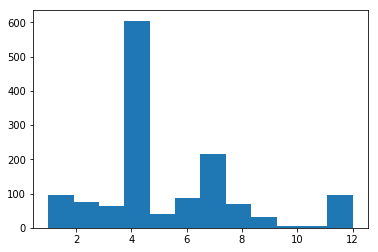

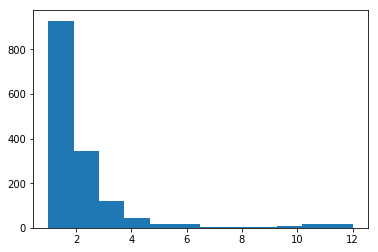

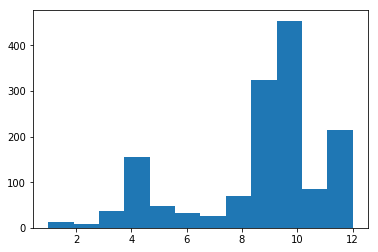

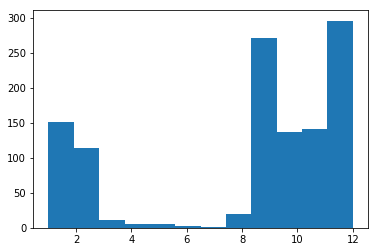

In [50]:
# plot density probabilities of max and min for Seattle and Boston
plt.hist(df_cal_sea_ext['max'], bins = 12)
plt.show()

plt.hist(df_cal_sea_ext['min'], bins = 12)
plt.show()

plt.hist(df_cal_bos_ext['max'], bins = 12)
plt.show()

plt.hist(df_cal_bos_ext['min'], bins = 12)
plt.show()

#trovare modo di abbellire gli istogrammi

In [ ]:
print((df_cal_sea_ext['min'] == 1).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 2).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 3).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 4).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 5).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 6).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 7).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 8).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 9).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 10).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 11).sum()/df_cal_sea_ext['min'].size,
(df_cal_sea_ext['min'] == 12).sum()/df_cal_sea_ext['min'].size,'\n')

print((df_cal_sea_ext['max'] == 1).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 2).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 3).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 4).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 5).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 6).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 7).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 8).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 9).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 10).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 11).sum()/df_cal_sea_ext['max'].size,
(df_cal_sea_ext['max'] == 12).sum()/df_cal_sea_ext['max'].size)


for i in range(1,13):
    print((df_cal_bos_ext['min'] == i).sum()/df_cal_bos_ext['min'].size)
print('\n')

for i in range(1,13):
    print((df_cal_bos_ext['max'] == i).sum()/df_cal_bos_ext['max'].size)
print('\n')


#months = 
#plt.plot()

In [ ]:
#count = (df_cal_sea_ext['min'] == 1).sum()/df_cal_sea_ext['min'].size
#count

In [ ]:
df_lis = pd.read_csv('.\Seattle\listings.csv')
df_lis.head()

In [ ]:
#df_lis.isna().sum()

In [ ]:
# remove all columns with url
df_lis = df_lis.loc[:,~df_lis.columns.str.contains('url', case = False)]
df_lis.head()

In [ ]:
# remove columns with unique values
unique_values = []
for col in list(df_lis.columns):
    if df_lis[col].unique().size==1:
        unique_values.append(col)
    
print(unique_values)

df_lis_no_unique = df_lis.drop(columns=unique_values)
df_lis_no_unique.columns

In [ ]:
# remove unnecessary columns
unnec_col = ['name', 
             'host_id', 'host_name', 'host_since', 'host_location', 'host_about', 'host_neighbourhood', 
             'neighborhood_overview', 'notes', 'street', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 
             'city', 'state', 'zipcode', 'smart_location', 'latitude', 'longitude', 'weekly_price', 'monthly_price',
             'calendar_updated', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 'first_review',
             'last_review', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
             'review_scores_communication', 'review_scores_location', 'review_scores_value']


df_lis_no_unn = df_lis_no_unique.drop(columns=unnec_col)
df_lis_no_unn.columns

In [ ]:
df_lis_no_unn.head()

In [ ]:
# removing unnecessary columns and dealing with nan
df_lis2 = df_lis_no_unn.drop(columns=['summary', 'space', 'description'])
df_lis2.head()

df_lis2.isna().mean()

In [ ]:
# dropping columns with no relevance for ratings, as well as columns with majority on nan values, like 
df_lis3 = df_lis2.drop(columns=['host_acceptance_rate', 'square_feet'])

# dropping rows with no ratings, as we can't perform correlation on those values
df_lis4 = df_lis3.dropna(axis=0, how='any', subset=['review_scores_rating'])

In [ ]:
df_lis4.head()
df_lis4.isna().mean()
#df_lis9.shape

In [ ]:
#df_lis5 = df_lis4.drop(columns = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
#                                  'review_scores_communication', 'review_scores_location', 'review_scores_value'])
#df_lis_clean.isna().mean()
#df_lis5.isna().mean()

In [ ]:
df_lis5 = df_lis4[~df_lis4['host_response_rate'].isnull()]
df_lis5.isna().mean()
df_lis5.head()

In [ ]:
# casting columns to their proper data types

# % host_response_rate, 
#t & f host_is_superhost, host_has_profile_pic, host_identity_verified, is_location_exact, instant_bookable, require_guest_profile_picture, require_guest_phone_verification
# $ price, security_deposit, extra_people
#df_lis6.loc[:,'host_reponse_rate'] = df_lis6['host_response_rate'].str.replace('%', '').astype(float)
df_lis5['host_response_rate'] = df_lis5['host_response_rate'].str.replace('%', '').astype(float)
df_lis5.replace('t', 1, inplace=True)
df_lis5.replace('f', 0, inplace=True)
df_lis5['price'] = df_lis5['price'].str.replace('$', '').astype(float)
df_lis5['security_deposit'] = df_lis5['security_deposit'].str.replace('$', '')
df_lis5['security_deposit'] = df_lis5['security_deposit'].str.replace(',', '').astype(float)
df_lis5['cleaning_fee'] = df_lis5['cleaning_fee'].str.replace('$', '').astype(float)
df_lis5['extra_people'] = df_lis5['extra_people'].str.replace('$', '').astype(float)

df_lis5.head()

In [ ]:
#df_lis_onlyr = df_lis[~df_lis['host_response_rate'].isnull()]
#print(df_lis_onlyr.shape, len(df_lis_onlyr.host_id.unique()))

In [ ]:
# dealing with NaNs
# listing without bathrooms are all entire house/apartment or private rooms. We assume that in each of these accomodations there is at least one bathroom.
# hosts with no response rate haw few listings. Since we want to incllude this feature in the analysis, we will remove those rows where the reposnse rste is null

# neighborhood_overview, notes and host_about to be dropped. Security deposit and cleaning fee to be filled with 0. Review_scores_something to be dropped.

df_lis5['bedrooms'].fillna(0, inplace=True) # as there can be homes w/o bedrooms
df_lis5['bathrooms'].fillna(1, inplace=True) # all houses are entire building apartments or single rooms, there has to be a bathroom
df_lis5['security_deposit'].fillna(0, inplace=True)
df_lis5['cleaning_fee'].fillna(0, inplace=True)
df_lis5.head()

In [ ]:
df_lis5.isna().mean()

In [ ]:
def extract_features(df, column_name):
    '''
    This function reproduces one hot encoding for those columns of a pandas dataframe that have a set or list of values 
    in each row
    
    Input:
    df - a pandas dataframe 
    column_name - the column whose values are sets or lists
    
    Output:
    new_df - a dataframe with one hot encoding for the selected column
    '''
    
    # create a set of the distinct values contained in df[column_name]
    item_set = set()
    for item in df[column_name]:
        #item = item.strip('{}')
        #item = item.strip('[]')
        #item = item.replace(' ', '')
        #item = item.replace("'", "")
        #item = item.replace('''"''', '')
        item = re.sub(r"[^a-zA-Z0-9\,\/\-]", "", item)
        item = item.split(',')
        new_entry = set(item)
        item_set.update(new_entry)
    
    # remove any white spaces or None
    try:
        item_set.remove('')
    except:
        pass
    try:
        item_set.remove('None')
    except:
        pass

    # one hot encoding of df[column_name]
    for item in list(item_set):  #[:-1]:
        booleans = df[column_name].str.contains(item)
        new_col = [int(boolean) for boolean in booleans]
        new_col_name = '{}_{}'.format(column_name, item)
        df[new_col_name] = new_col
        
    # remove original column from dataframe df
    new_df = df.drop(columns = column_name)
    
    return new_df

In [ ]:
# Extracting features from categorical columns

df_lis6 = extract_features(df_lis5, 'amenities')
df_lis7 = extract_features(df_lis6, 'host_verifications')

one_hot_columns = ['host_response_time', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 'cancellation_policy']
df_lis8 = pd.get_dummies(data = df_lis7, columns = one_hot_columns)  #, drop_first=True)
df_lis8.head()



In [ ]:
# One Hot Encoding for transportation

transport_means = ['Bus', 'Light Rail', 'Ferry', 'Heavy Rail', 'Train', 'Metro', 'NaN']

df_lis8['transit'].fillna("NaN", inplace=True)

for mean in transport_means:  #[:-1]:
    booleans = df_lis8['transit'].str.contains(mean, False)    #re.find(mean, 'hello', re.IGNORECASE)
    new_col = [int(boolean) for boolean in booleans]
    new_col_name = 'transit_{}'.format(mean)
    df_lis8[new_col_name] = new_col

df_lis8.drop(columns='transit', inplace=True)
df_lis8.head()

In [ ]:
df_lis9 = df_lis8.drop(columns='id')
df_lis9.head()

In [ ]:
corr = df_lis9.corr()
#corr
corr.unstack()['price'].dropna().sort_values(ascending=False)

#fig, ax = plt.subplots(figsize=(40,40))         # Sample figsize in inches
#sns.heatmap(corr, ax=ax)

In [ ]:
# linear regression
X = df_lis9.drop(columns='price')
y = df_lis9.price

#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#fit the model and obtain pred response
lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
y_pred = lm_model.predict(X_test)
#y_train_preds = lm_model.predict(X_train)

#append the r2 value from the test set
r2_score(y_test, y_pred)
#r2_scores_test.append(r2_score(y_test, y_test_preds))
#r2_scores_train.append(r2_score(y_train, y_train_preds))
#results[str(cutoff)] = r2_score(y_test, y_test_preds)

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

r2_score(y_test, y_pred_log)

In [ ]:
# using support vector machines
regr = svm.SVR()
regr.fit(X_train, y_train)

y_pred_svm = regr.predict(X_test)
r2_score(y_test, y_pred_svm)

In [ ]:
# using random forest classifier
rfr = RandomForestRegressor(n_estimators=300)
rfr.fit(X_train, y_train)

y_pred_rfr = rfr.predict(X_test)
r2_score(y_test, y_pred_rfr)

In [ ]:
df_lis['review_scores_rating'].unique()
df_lis_sort_values = df_lis.sort_values(by='review_scores_rating')
df_lis_sort_values.head()

In [ ]:
df_rev = pd.read_csv(".\\Seattle\\reviews.csv")
df_rev.head()

In [ ]:
df_rev[df_rev['listing_id'] == 7202016]

In [ ]:
len(df_rev.listing_id.unique())

In [ ]:
len(df_lis.id.unique())

In [ ]:
len(df_lis[df_lis['number_of_reviews'] == 0])

In [ ]:
df_lis[['neighbourhood', 'neighbourhood_group_cleansed']]